In [2]:
import pandas as pd

In [37]:
df = pd.read_csv('data.csv').dropna(axis=1)
df.head()
df = df[df.resistance < 1e3]
df = df.drop(['passes'], axis=1)
X = df[['power', 'time','pressure']]
y = df['resistance']

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
y_train, y_test = train_test_split(y, test_size=0.2, random_state=42)


In [39]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 122 to 77
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   power     80 non-null     int64
 1   time      80 non-null     int64
 2   pressure  80 non-null     int64
dtypes: int64(3)
memory usage: 2.5 KB


In [40]:
numerical_features = [
    "power",
    "time",
    "pressure"
]

In [41]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer
# from sklearn.preprocessing import OneHotEncoder

mlp_preprocessor = ColumnTransformer(
    transformers=[
        ("num", QuantileTransformer(n_quantiles=100), numerical_features),
        # ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)
mlp_preprocessor

ColumnTransformer(transformers=[('num', QuantileTransformer(n_quantiles=100),
                                 ['power', 'time', 'pressure'])])

In [17]:
# from sklearn.preprocessing import OrdinalEncoder

hgbdt_preprocessor = ColumnTransformer(
    transformers=[
        # ("cat", OrdinalEncoder(), categorical_features),
        ("num", "passthrough", numerical_features),
    ],
    sparse_threshold=1,
    verbose_feature_names_out=False,
).set_output(transform="pandas")
hgbdt_preprocessor

ColumnTransformer(sparse_threshold=1,
                  transformers=[('num', 'passthrough',
                                 ['power', 'time', 'pressure'])],
                  verbose_feature_names_out=False)

In [42]:
from time import time
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline

print("Training MLPRegressor...")
tic = time()
mlp_model = make_pipeline(
    mlp_preprocessor,
    MLPRegressor(
        hidden_layer_sizes=(30, 15),
        learning_rate_init=0.01,
        early_stopping=True,
        random_state=0,
    ),
)
mlp_model.fit(X_train, y_train)
print(f"done in {time() - tic:.3f}s")
print(f"Test R2 score: {mlp_model.score(X_test, y_test):.2f}")

Training MLPRegressor...
done in 0.034s
Test R2 score: 0.04


/home/hud/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2623: UserWarning: n_quantiles (100) is greater than the total number of samples (80). n_quantiles is set to n_samples.
  warnings.warn(


In [22]:
from sklearn.ensemble import HistGradientBoostingRegressor

print("Training HistGradientBoostingRegressor...")
tic = time()
hgbdt_model = make_pipeline(
    hgbdt_preprocessor,
    HistGradientBoostingRegressor(
        random_state=0
    ),
)
hgbdt_model.fit(X_train, y_train)
print(f"done in {time() - tic:.3f}s")
print(f"Test R2 score: {hgbdt_model.score(X_test, y_test):.2f}")



Training HistGradientBoostingRegressor...
done in 59.585s
Test R2 score: -32.45


Computing partial dependence plots...


done in 2.300s


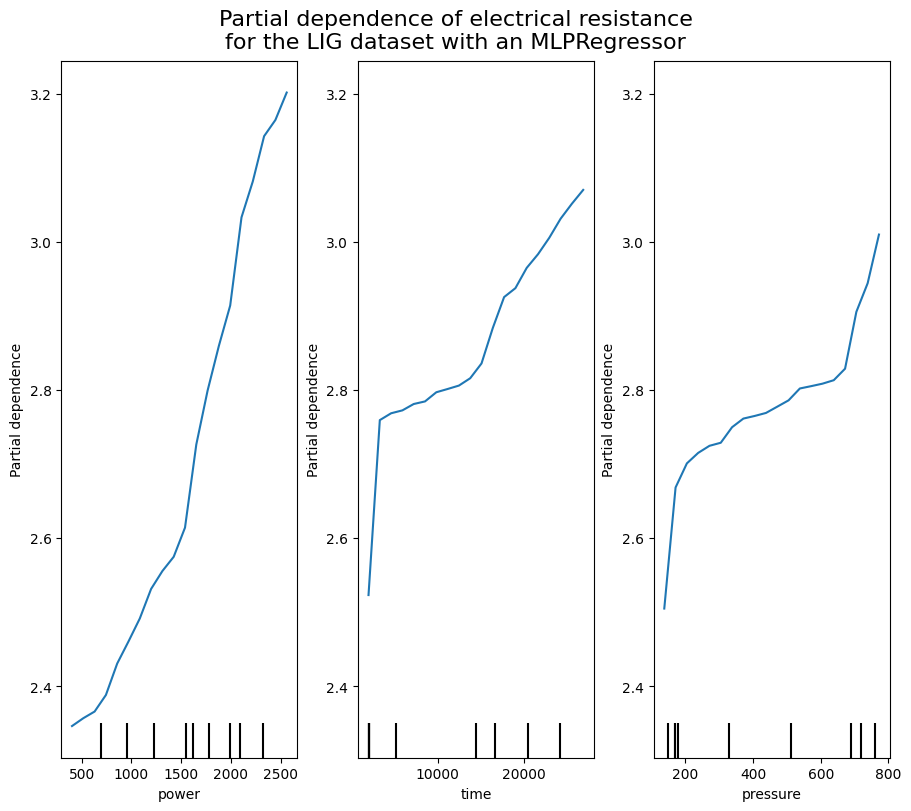

In [34]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}

print("Computing partial dependence plots...")
features_info = {
    # features of interest
    "features": ["power", "time", "pressure"],
    # type of partial dependence plot
    "kind": "average",
    # information regarding categorical features
    # "categorical_features": categorical_features,
}
tic = time()
_, ax = plt.subplots(ncols=3, nrows=1, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    mlp_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
_ = display.figure_.suptitle(
    "Partial dependence of electrical resistance\n"
    "for the LIG dataset with an MLPRegressor",
    fontsize=16,
)

Computing partial dependence plots...
done in 0.255s


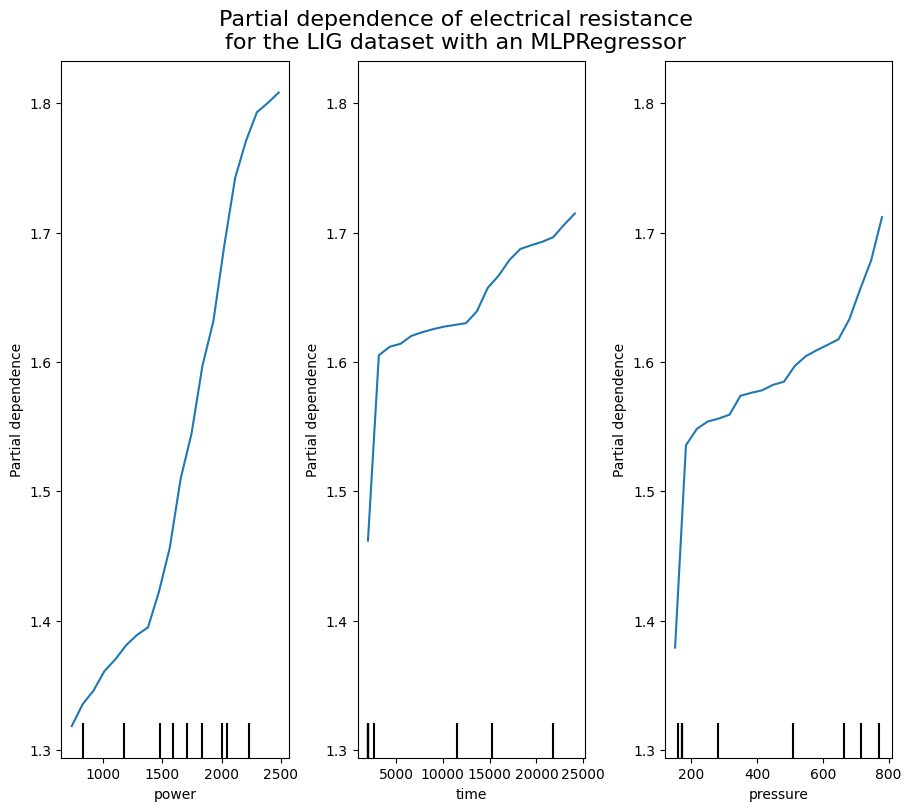

In [43]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}

print("Computing partial dependence plots...")
features_info = {
    # features of interest
    "features": ["power", "time", "pressure"],
    # type of partial dependence plot
    "kind": "average",
    # information regarding categorical features
    # "categorical_features": categorical_features,
}
tic = time()
_, ax = plt.subplots(ncols=3, nrows=1, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    mlp_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
_ = display.figure_.suptitle(
    "Partial dependence of electrical resistance\n"
    "for the LIG dataset with an MLPRegressor",
    fontsize=16,
)

Computing partial dependence plots...
done in 1.097s


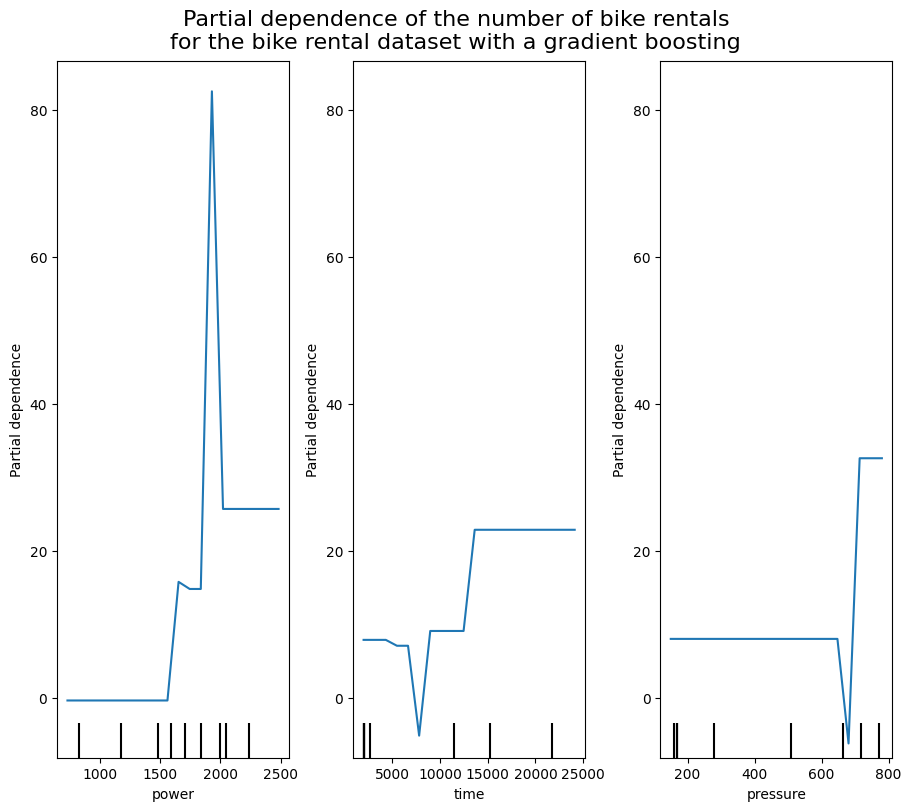

In [23]:
print("Computing partial dependence plots...")
tic = time()
_, ax = plt.subplots(ncols=3, nrows=1, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    hgbdt_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
_ = display.figure_.suptitle(
    "Partial dependence of the number of bike rentals\n"
    "for the bike rental dataset with a gradient boosting",
    fontsize=16,
)

Computing partial dependence plots...
done in 17.351s


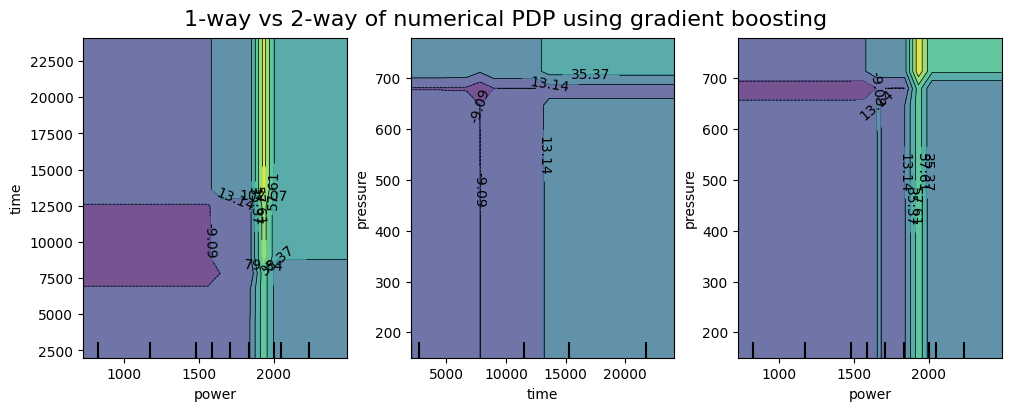

In [25]:
print("Computing partial dependence plots...")
features_info = {
    "features": [("power", "time"), ("time", "pressure"), ("power", "pressure")],
    "kind": "average",
}
_, ax = plt.subplots(ncols=3, figsize=(10, 4), constrained_layout=True)
tic = time()
display = PartialDependenceDisplay.from_estimator(
    hgbdt_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
_ = display.figure_.suptitle(
    "1-way vs 2-way of numerical PDP using gradient boosting", fontsize=16
)

Computing partial dependence plots...
done in 3.620s


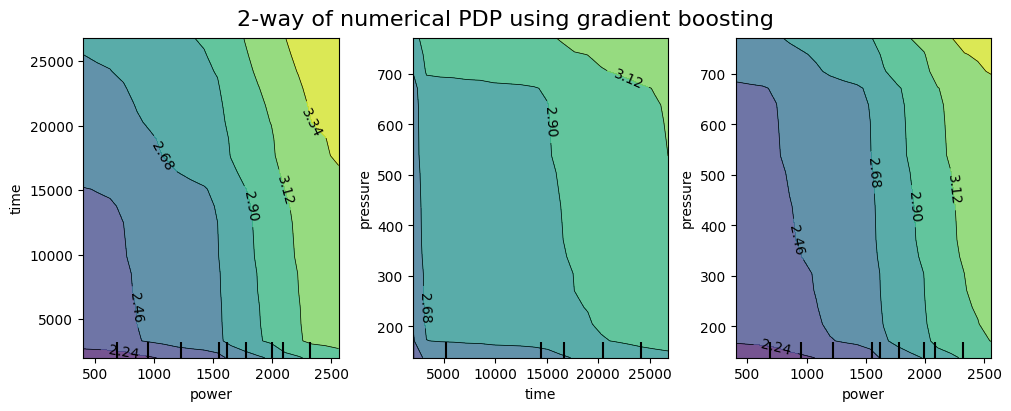

In [36]:
print("Computing partial dependence plots...")
features_info = {
    "features": [("power", "time"), ("time", "pressure"), ("power", "pressure")],
    "kind": "average",
}
_, ax = plt.subplots(ncols=3, figsize=(10, 4), constrained_layout=True)
tic = time()
display = PartialDependenceDisplay.from_estimator(
    mlp_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
_ = display.figure_.suptitle(
    "2-way of numerical PDP using gradient boosting", fontsize=16
)

Computing partial dependence plots...
done in 6.387s


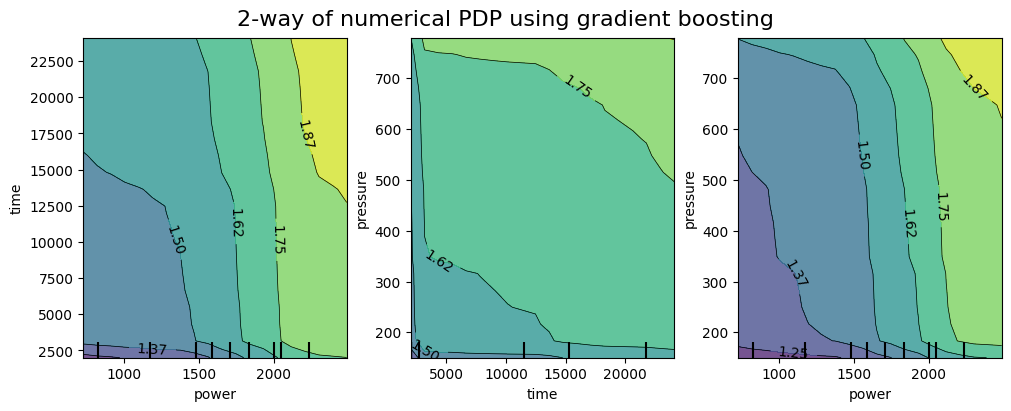

In [44]:
print("Computing partial dependence plots...")
features_info = {
    "features": [("power", "time"), ("time", "pressure"), ("power", "pressure")],
    "kind": "average",
}
_, ax = plt.subplots(ncols=3, figsize=(10, 4), constrained_layout=True)
tic = time()
display = PartialDependenceDisplay.from_estimator(
    mlp_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
_ = display.figure_.suptitle(
    "2-way of numerical PDP using gradient boosting", fontsize=16
)

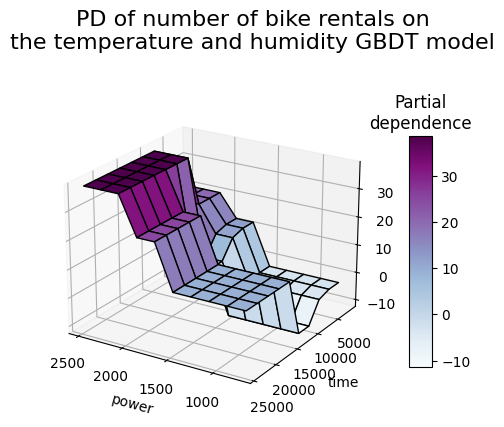

In [46]:
import numpy as np

# unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401

from sklearn.inspection import partial_dependence

fig = plt.figure(figsize=(5.5, 5))

features = ("power", "time")
pdp = partial_dependence(
    hgbdt_model, X_train, features=features, kind="average", grid_resolution=10
)
XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1])
Z = pdp.average[0].T
ax = fig.add_subplot(projection="3d")
fig.add_axes(ax)

surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor="k")
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
fig.suptitle(
    "PD of number of bike rentals on\nthe temperature and humidity GBDT model",
    fontsize=16,
)
# pretty init view
ax.view_init(elev=22, azim=122)
clb = plt.colorbar(surf, pad=0.08, shrink=0.6, aspect=10)
clb.ax.set_title("Partial\ndependence")
plt.show()